# Coding Discussion #6
Madeline Kinnaird

# Load all the things!

#### Packages

In [1]:
#data manipulation
import pandas as pd
import numpy as np

## cleaning data
import missingno as msno
from scipy import stats

## visualizations 
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

## modeling
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

## silence warnings 
import warnings
warnings.filterwarnings("ignore")

#### Data

In [2]:
## import data
test_data = pd.read_csv("../test_data.csv")
train_data = pd.read_csv("../train_data.csv")

## merge data for analysis
frames = [test_data , train_data]
data = pd.concat(frames)


In [3]:
## inspect our data a bit
data.describe()


,OBJECTID,BATHRM,HF_BATHRM,HEAT,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,...,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,LN_PRICE
count,58121.000000,58120.000000,58119.000000,58120.000000,58120.000000,58108.000000,58117.000000,58116.000000,33336.000000,58121.000000,...,58120.000000,58120.000000,58120.000000,58120.000000,58120.000000,58119.000000,58119.000000,58121.000000,58121.000000,58121.000000
mean,52061.733952,2.204026,0.649495,6.847626,1.221576,7.429459,3.429220,1931.482845,2004.261429,1969.791710,...,4.299260,3.708138,13.447350,3.963094,6.297109,1.251415,0.641116,13.277937,3171.446155,12.928077
std,31173.752433,1.067458,0.607217,5.149936,0.624942,2.370431,1.199319,83.097709,16.629371,16.934042,...,1.374629,0.746899,4.033265,3.332154,2.093512,0.662110,0.909725,4.178889,3145.140487,0.864354
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,1900.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000
25%,24369.000000,1.000000,0.000000,1.000000,1.000000,6.000000,3.000000,1913.000000,2002.000000,1957.000000,...,3.000000,3.000000,14.000000,1.000000,6.000000,1.000000,0.000000,11.000000,1520.000000,12.388394
50%,51507.000000,2.000000,1.000000,7.000000,1.000000,7.000000,3.000000,1929.000000,2008.000000,1967.000000,...,4.000000,4.000000,14.000000,2.000000,6.000000,1.000000,0.000000,12.000000,2214.000000,12.994530
75%,79541.000000,3.000000,1.000000,13.000000,1.000000,8.000000,4.000000,1947.000000,2013.000000,1975.000000,...,5.000000,4.000000,14.000000,6.000000,6.000000,1.000000,1.000000,13.000000,4000.000000,13.527828
max,107154.000000,24.000000,11.000000,13.000000,6.000000,101.000000,54.000000,2018.000000,2019.000000,2018.000000,...,12.000000,6.000000,24.000000,15.000000,11.000000,44.000000,13.000000,39.000000,187301.000000,17.038378


#### A quick look:
After looking at a brief description of the data, we see some things right away. 
- There are definitely some outliers in this data that we will likely want to remove.
    - EX: A property with *24 bathrooms* might skew whatever predictor we come up with (seeing as the mean is 2 bathrooms!)
    - So we'll want to identify the outliers and address them.
    
- This data description only includes some of the data (the numeric data)
    - We'll need to address handling columns that are objects.



# Clean all the things!

#### Categorical Variables
Generally speaking, it is easier to work with numeric data than objects or strings. So we'll divide the data and then determine which categorical or quantitative data should be encoded for future analysis.

In [4]:
## split data into numeric and categorical 

num = data.select_dtypes(include = ['float64', 'int64']).iloc[:,1:]
cat = data.select_dtypes(include = ['object']).iloc[:,1:]


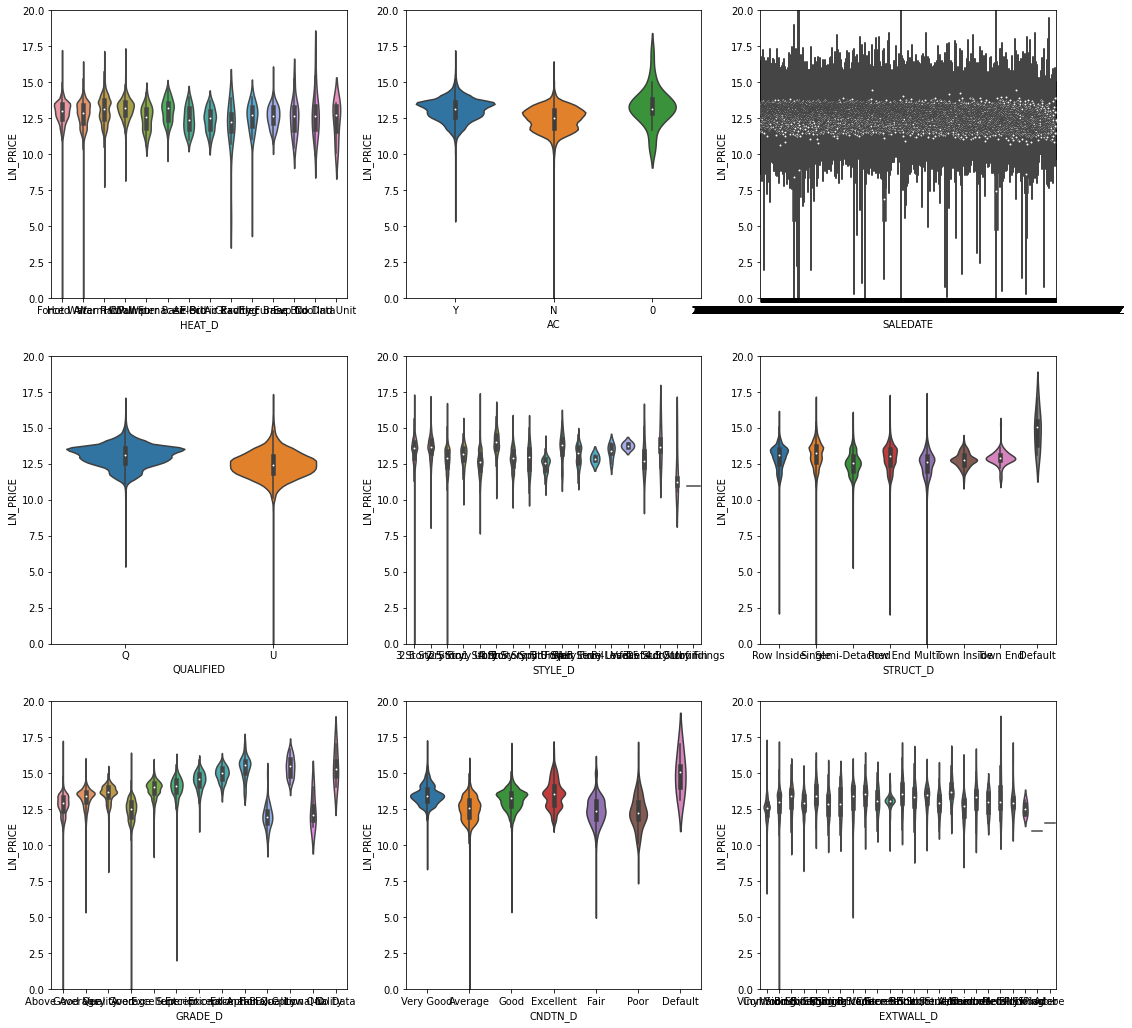

In [5]:
## loop through and plot cat vars

plt.figure(figsize=(18,18))
for i in range(9):
    ii = '33'+str(i+1)
    plt.subplot(ii)
    feature = cat.columns.values[i]
    sns.violinplot(x = cat[feature], y = data['LN_PRICE'])
    ax=plt.gca() 
    ax.set_ylim([0,20])

#### Encoding Categorical Variables

A lot of the categorical are the 'decription variables, for example:
- HEAT_D
- GRADE_D
- STYLE_D
- STRUCT_D
- GRADE_D
- CNDTN_D
- EXTWALL_D

Luckily these variables already are accompanied by numeric data, so we can look at the above graphs to understand their distribution but do not need to figure out how to encode them.

Some variables that do need to be encoded:
1. AC <br>
2. SALEDATE
3. QUALIFIED

#### 1) AC Variable
We see that AC has a binary result where N=0, Y=1, and then 0 = NA. Before we decide what to do, let's see how many of each value we have.

In [6]:
## check how many values of each we have
data['AC'].value_counts()

Y    42304
N    15790
0       26
Name: AC, dtype: int64

There are only 26 0's/NAs. Let's just drop those instances and make our lives easier!

In [7]:
## change zeros to NAs
data['AC']=data['AC'].replace(0, np.nan)

## change Y/N to numeric
AC_map = {'Y': 1, 'N': 0}
data['AC'] = data['AC'].map(AC_map)

## drop NAs from data

#### 2) SALEDATE Variable
Above in the violin charts, we quickly see that we need to do something about the sale date variable. Below we will decompose the date variable into more features to see if any of them are meaningful in relation to sale price.

In [8]:
## determine columns that are date columns
date_columns = [col for col in data.columns if 'DATE' in col]

## Breaking out year, month, day in month, and day of week
for var in date_columns:
    data[var] = pd.to_datetime(data[var])
    data[var + ' Year'] = data[var].dt.year
    data[var + ' Month'] = data[var].dt.month
    data[var + ' Day'] = data[var].dt.day
    data[var + ' Day of Week'] = data[var].dt.dayofweek
    

In [9]:
## add newly create date columns to our list

date_columns = [col for col in data.columns if 'DATE' in col]


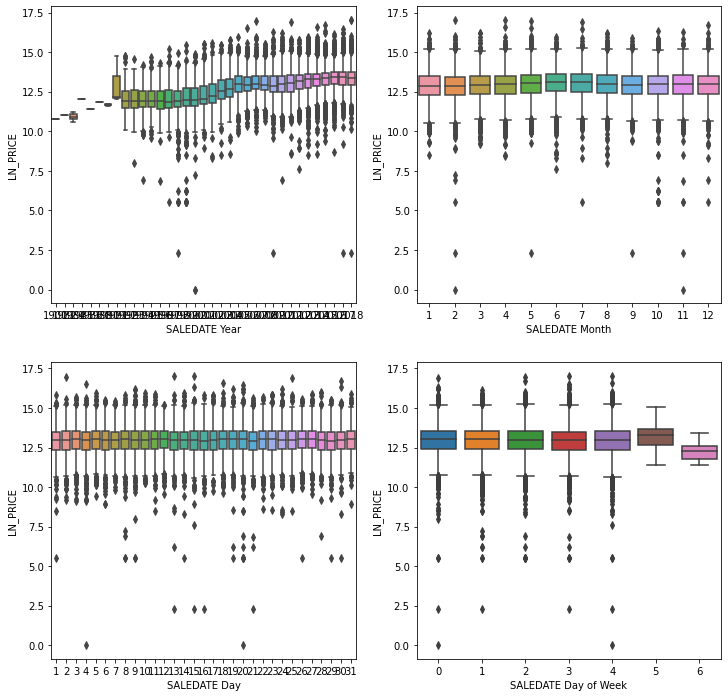

In [10]:
plt.figure(figsize=(12,12))
for i in range(1,5):
    ii = '22'+str(i)
    plt.subplot(ii)
    feature = date_columns[i]
    sns.boxplot(x=feature, y='LN_PRICE', data=data)


#### Weekends
From the box plots above, I am slightly curious about houses sold on weekends and what is going on there.

In [162]:
## counts of sales by day of week
data['SALEDATE Day of Week'].value_counts()

1    12422
2    12077
3    11589
4    11236
0    10738
5       45
6       14
Name: SALEDATE Day of Week, dtype: int64

In [163]:
## create a binary feature just to check distribution
weekend_map = {0: 0, 1: 0, 2:0, 3:0, 4:0, 5:1, 6:1}
data['WEEKEND'] = data['SALEDATE Day of Week'].map(weekend_map)

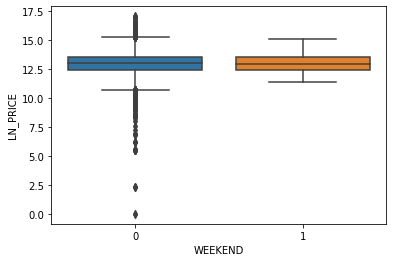

In [165]:
sns.boxplot(x='WEEKEND', y='LN_PRICE', data=data)

Yep, nothing too crazy. Just wanted to check and be sure.

#### 3) Qualified Variable

Last categorical variable to change!


In [11]:
## change Q/U to numeric
AC_map = {'Q': 1, 'U': 0}
data['QUALIFIED'] = data['QUALIFIED'].map(AC_map)

#### Data Types

And finally, we're going to make sure that we have a nice neat dataframe full of numerical data in order to identify the outliers.

In [143]:
## select only numeric data
dataNum = data.select_dtypes(include = ['float64', 'int64']).iloc[:,0:]


#### Handle Outliers

Words words words

In [144]:
## IQR for each column

Q1 = dataNum.quantile(0.25)
Q3 = dataNum.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

OBJECTID                55172.000000
BATHRM                      2.000000
HF_BATHRM                   1.000000
HEAT                       12.000000
AC                          1.000000
NUM_UNITS                   0.000000
ROOMS                       2.000000
BEDRM                       1.000000
AYB                        34.000000
YR_RMDL                    11.000000
EYB                        18.000000
STORIES                     0.000000
QUALIFIED                   0.000000
SALE_NUM                    2.000000
GBA                       768.000000
BLDG_NUM                    0.000000
STYLE                       0.000000
STRUCT                      6.000000
GRADE                       2.000000
CNDTN                       1.000000
EXTWALL                     0.000000
ROOF                        5.000000
INTWALL                     0.000000
KITCHENS                    0.000000
FIREPLACES                  1.000000
USECODE                     2.000000
LANDAREA                 2480.000000
L

In [230]:
## print outliers, true or false
#print((dataNum < (Q1 - 3 * IQR)) | (dataNum > (Q3 + 3 * IQR)))


In [146]:
## remove rows with outliers

data_no_outliers = dataNum[~((dataNum < (Q1 - 5 * IQR)) |(dataNum > (Q3 + 5 * IQR))).any(axis=1)]
data_no_outliers.shape


(17785, 33)

In [17]:
## create function for outliers so we can call it later when we use the split/test data

In [16]:
def removeOutliers(data):
    '''
    Function: Based on IQR, removes rows with outliers.
    
    Input: data (df where all types are numeric or ints)
    Output: df without outliers
    '''
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    df = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df

#### Missing Data

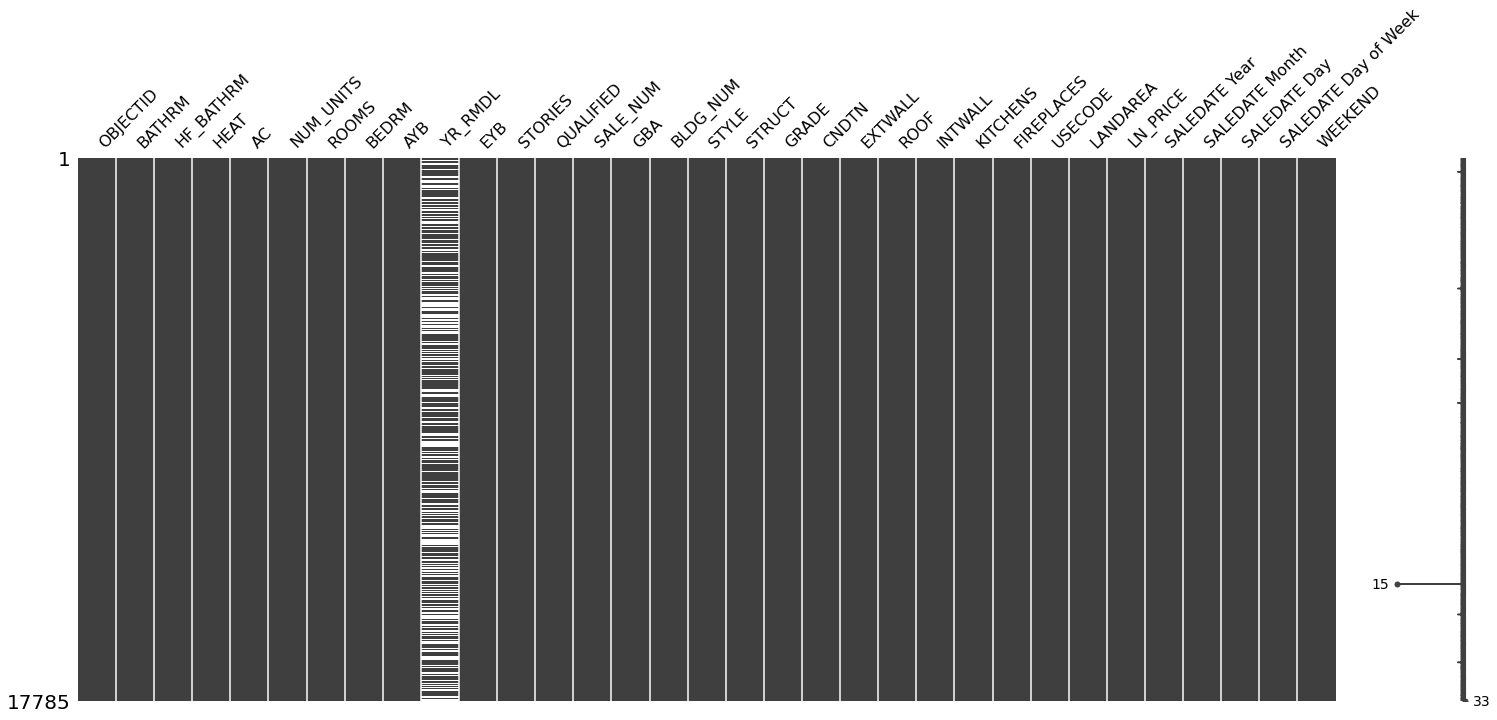

In [147]:
msno.matrix(data_no_outliers)

We are going to assume that the NA's in remodel year likely imply that the property was not remodeled, so we're going to turn this into another binary feature.

In [148]:
## create new column for remodeled or no

data_no_outliers['REMODELED'] = np.where(data_no_outliers['YR_RMDL'].isnull(), 1, 0)

In [149]:
data_no_outliers.describe()

,OBJECTID,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,...,FIREPLACES,USECODE,LANDAREA,LN_PRICE,SALEDATE Year,SALEDATE Month,SALEDATE Day,SALEDATE Day of Week,WEEKEND,REMODELED
count,17785.000000,17784.000000,17784.000000,17784.000000,17782.000000,17784.0,17784.000000,17783.000000,17785.000000,10809.000000,...,17784.000000,17785.000000,17785.000000,17785.000000,17785.000000,17785.000000,17785.000000,17785.000000,17785.0,17785.000000
mean,51952.235704,1.839294,0.614035,6.913686,0.709481,1.0,6.710920,3.056908,1930.609559,2005.665094,...,0.498932,11.601125,2538.474951,12.902883,2009.205117,6.677031,15.383525,1.999775,0.0,0.392241
std,29568.004062,0.821829,0.585046,5.188276,0.454014,0.0,1.506604,0.744507,20.233670,11.991946,...,0.721142,0.819534,1769.495312,0.723751,7.136804,3.287171,8.997979,1.391204,0.0,0.488264
min,13.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.000000,0.000000,1776.000000,1947.000000,...,0.000000,11.000000,216.000000,9.249561,1982.000000,1.000000,1.000000,0.000000,0.0,0.000000
25%,24081.000000,1.000000,0.000000,1.000000,0.000000,1.0,6.000000,3.000000,1919.000000,2003.000000,...,0.000000,11.000000,1473.000000,12.429216,2004.000000,4.000000,7.000000,1.000000,0.0,0.000000
50%,54104.000000,2.000000,1.000000,7.000000,1.000000,1.0,6.000000,3.000000,1930.000000,2010.000000,...,0.000000,11.000000,1950.000000,13.010873,2011.000000,7.000000,15.000000,2.000000,0.0,0.000000
75%,75401.000000,2.000000,1.000000,13.000000,1.000000,1.0,7.000000,3.000000,1942.000000,2013.000000,...,1.000000,12.000000,2880.000000,13.457406,2015.000000,9.000000,23.000000,3.000000,0.0,1.000000
max,107116.000000,7.000000,5.000000,13.000000,1.000000,1.0,17.000000,9.000000,2018.000000,2019.000000,...,6.000000,15.000000,15996.000000,15.424948,2018.000000,12.000000,31.000000,4.000000,0.0,1.000000


# Explore all the things!

#### Dependent Variable Distribution

(0.0, 20.0, 0.0, 10500.0)

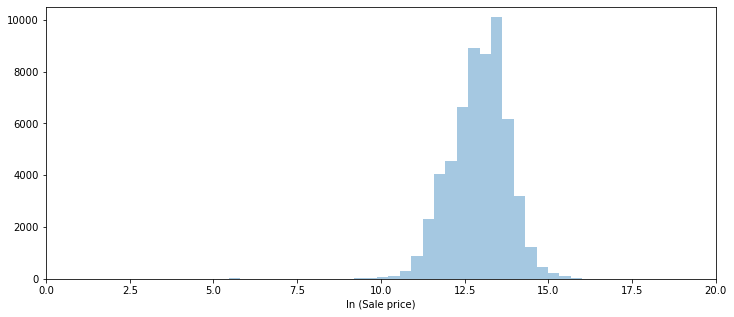

In [150]:
# Set up the matplotlib figure
plt.figure(figsize=(12,5))


sns.distplot(data['LN_PRICE'],kde=False)
plt.xlabel('ln (Sale price)')
plt.axis([0,20,0,10500])

#### Correlation Matrix

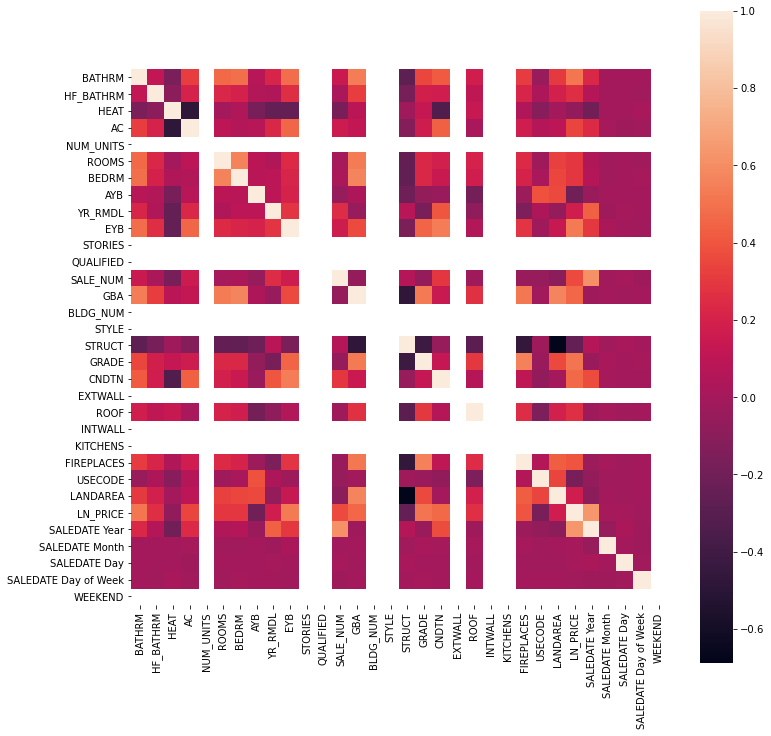

In [151]:
## prep data for correlation matrix
corr = data_no_outliers.select_dtypes(include = ['float64', 'int64']).iloc[:,1:].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12,12))
sns.heatmap(corr, vmax=1, square=True)



In [156]:
data_no_outliers.sample(10)

,OBJECTID,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,...,FIREPLACES,USECODE,LANDAREA,LN_PRICE,SALEDATE Year,SALEDATE Month,SALEDATE Day,SALEDATE Day of Week,WEEKEND,REMODELED
2444,83333,1.0,0.0,13.0,0.0,1.0,5.0,2.0,1942.0,NaN,...,0.0,11,1600,11.289782,1993,7,21,2,0,1
10793,73948,2.0,0.0,13.0,0.0,1.0,9.0,3.0,1924.0,1992.0,...,0.0,11,1700,13.017003,2016,6,3,4,0,0
15952,59189,1.0,0.0,13.0,0.0,1.0,7.0,4.0,1925.0,NaN,...,0.0,11,1502,13.017003,2018,1,26,4,0,1
10150,82557,1.0,0.0,8.0,0.0,1.0,4.0,2.0,1926.0,2004.0,...,0.0,11,923,13.091904,2018,4,24,1,0,0
36690,17168,1.0,1.0,13.0,0.0,1.0,6.0,4.0,1909.0,2011.0,...,2.0,11,2228,13.038982,2010,11,24,2,0,0
8073,18055,4.0,1.0,13.0,1.0,1.0,8.0,5.0,1922.0,2007.0,...,0.0,11,1743,13.527695,2008,4,8,1,0,0
31213,11419,2.0,1.0,1.0,1.0,1.0,6.0,3.0,1910.0,2012.0,...,2.0,11,2720,13.437904,2012,8,22,2,0,0
1416,32564,3.0,1.0,7.0,1.0,1.0,7.0,4.0,1946.0,NaN,...,1.0,11,3128,13.776770,2016,8,10,2,0,1
29671,86620,2.0,0.0,1.0,1.0,1.0,7.0,3.0,1941.0,2014.0,...,0.0,13,2226,12.468437,2014,2,12,2,0,0
703,11360,2.0,1.0,1.0,1.0,1.0,6.0,3.0,1910.0,2015.0,...,1.0,11,1102,13.526494,2016,8,31,2,0,0


In [152]:
## order list based on correlation with sale price
corr_list = corr['LN_PRICE'].sort_values(axis=0,ascending=False).iloc[1:]
corr_list

SALEDATE Year           0.635296
EYB                     0.525371
BATHRM                  0.513229
GRADE                   0.511259
CNDTN                   0.466605
GBA                     0.461485
FIREPLACES              0.396781
SALE_NUM                0.362206
AC                      0.345796
ROOMS                   0.292000
BEDRM                   0.291035
ROOF                    0.263112
HF_BATHRM               0.259990
YR_RMDL                 0.178160
LANDAREA                0.170531
SALEDATE Day            0.009387
SALEDATE Month          0.009129
SALEDATE Day of Week   -0.011503
HEAT                   -0.069006
USECODE                -0.170900
AYB                    -0.194871
STRUCT                 -0.250328
NUM_UNITS                    NaN
STORIES                      NaN
QUALIFIED                    NaN
BLDG_NUM                     NaN
STYLE                        NaN
EXTWALL                      NaN
INTWALL                      NaN
KITCHENS                     NaN
WEEKEND   

#### Plot Individual Correlations

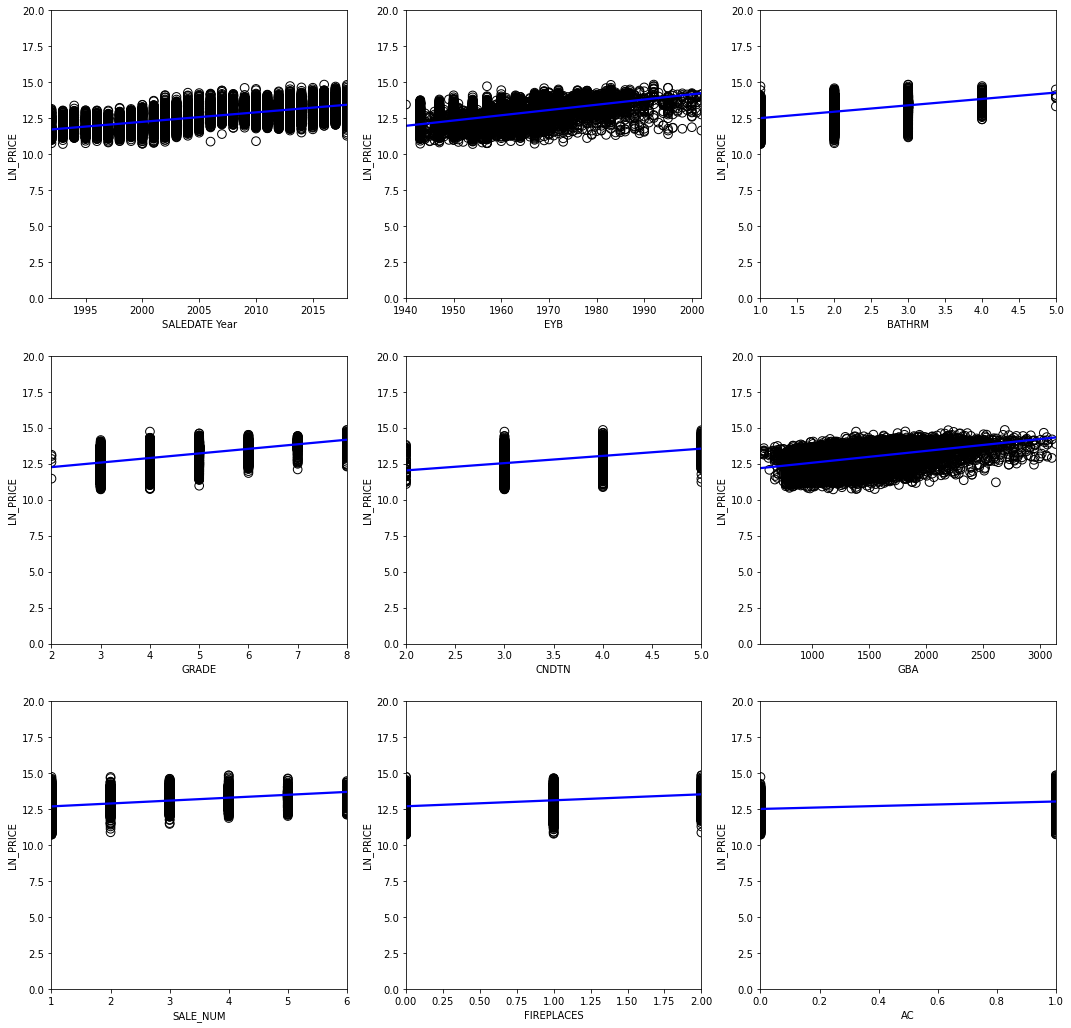

In [51]:
## figure out how to jitter

plt.figure(figsize=(18,18))
for i in range(9):
    ii = '33'+str(i+1)
    plt.subplot(ii)
    feature = corr_list.index.values[i]
    plt.scatter(data_no_outliers[feature], data_no_outliers['LN_PRICE'], facecolors='none',edgecolors='k',s = 75)
    sns.regplot(x = feature, y = 'LN_PRICE', data = data_no_outliers,scatter=False, color = 'Blue')
    ax=plt.gca() 
    ax.set_ylim([0,20])
 

# Feature Engineering, Importance, Selection

# Modeling

In [180]:
## make sure we're using the same data splits for each fold
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

## setting our metric for performance metrics
use_metrics = ["neg_mean_squared_error"]

#### Split data
Since the data was originally split for us, we need to reconstruct the original divisions. We can do this using the ID.

In [166]:
## merge data back together
test_data.head() 

test=test_data[['OBJECTID']]
train=train_data[['OBJECTID']]

tmpTest = pd.merge(test, data_no_outliers, on='OBJECTID', how='left')
tmpTrain = pd.merge(train, data_no_outliers, on='OBJECTID', how='left')

In [167]:
## drop values where certain columns are blank
cols_to_ignore = ['YR_RMDL']

tmpTest = tmp1.dropna(subset=tmp1.columns.difference(cols_to_ignore))
tmpTrain = tmp2.dropna(subset=tmp2.columns.difference(cols_to_ignore))

In [222]:
## create training and testing split

train_X = tmpTrain.drop(['LN_PRICE'], axis=1)
train_y = np.asarray(tmpTrain['LN_PRICE'])

test_X = tmpTest.drop(['LN_PRICE'], axis=1)
test_y = np.asarray(tmpTest['LN_PRICE'])

#### Linear Model

In [223]:
#lm_scores = cross_validate(LM(),train_X,train_y, cv = fold_generator, scoring = use_metrics)
lm_scores = cross_validate(LM(),train_X,train_y, scoring = use_metrics)

##### KNN

In [224]:
#knn_scores = cross_validate(KNN(),train_X,train_y, cv = fold_generator, scoring =use_metrics)
knn_scores = cross_validate(KNN(),train_X,train_y, scoring =use_metrics)

#### Decision Tree

In [225]:
#dt_scores = cross_validate(DTree(),train_X,train_y, cv = fold_generator, scoring =use_metrics)
dt_scores = cross_validate(DTree(),train_X,train_y, scoring =use_metrics)

In [ ]:
mod = DTree(max_depth=3) # Initialize the modeling object (just as we did)
mod.fit(train_X,train_y) # Fit the mode

# Plot the tree
plt.figure(figsize=(12,8),dpi=300)
rules = tree.plot_tree(mod,feature_names = col_names,fontsize=8)

#### Bagging

In [226]:
#bag_scores = cross_validate(Bag(),train_X,train_y, cv = fold_generator, scoring =use_metrics)
bag_scores = cross_validate(Bag(),train_X,train_y, scoring =use_metrics)

#### Random Forest

In [227]:
#rf_scores = cross_validate(RF(),train_X,train_y, cv = fold_generator, scoring =use_metrics)
rf_scores = cross_validate(RF(),train_X,train_y, scoring =use_metrics)

# Compare Models

In [228]:
# Output is a dictionary 
lm_scores

{'fit_time': array([0.00498557, 0.00398946, 0.00449538, 0.00398922, 0.00498581]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_neg_mean_squared_error': array([nan, nan, nan, nan, nan])}

In [229]:
# Collect all the metrics we care about as a dictionary 
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores

,Model,MSE
0,lm,NaN
1,lm,NaN
2,lm,NaN
3,lm,NaN
4,lm,NaN
5,knn,NaN
6,knn,NaN
7,knn,NaN
8,knn,NaN
9,knn,NaN
